In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import stats
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (12, 12)

In [3]:
evi_img_dir = "/home/dat/Workspace/Thesis/lettuce_detector/data/raw/2017-10-27_Ortho/EVI/lettuce"
csv_file = "/home/dat/Workspace/Thesis/data/Spreadsheet/Lettuce/2017-10-27.csv"

### Distribution of EVI values

In [4]:
lettuce_evi = {}
for fname in os.listdir(evi_img_dir):
    img = np.asarray(Image.open(os.path.join(evi_img_dir, fname)).convert("L"))
    evi = (np.average(img) - 128) / 128
    lettuce_evi[fname.split(".")[0]] = evi

In [5]:
evi_values = list(lettuce_evi.values())

print("Average: %.4f" % np.average(evi_values))
print("Std Dev: %.4f" % np.std(evi_values))

Average: 0.9148
Std Dev: 0.0863


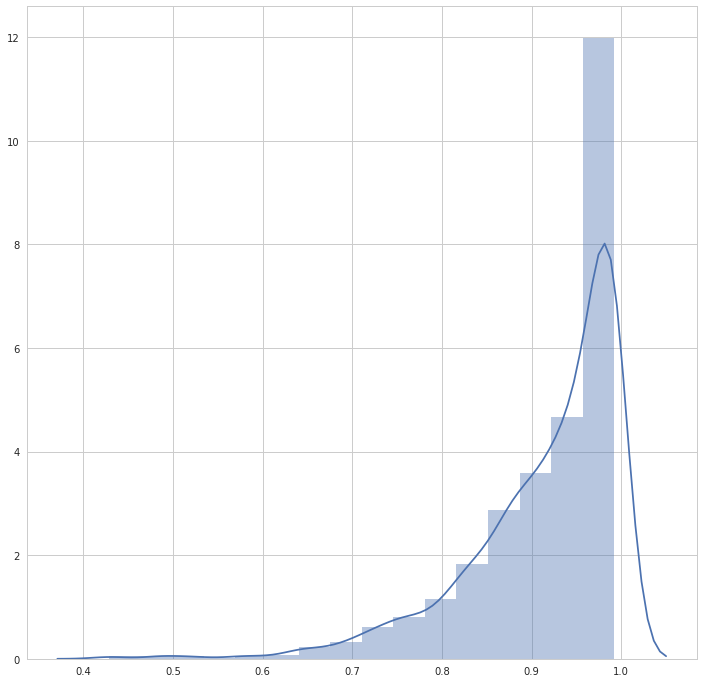

In [6]:
sns.distplot(evi_values, bins=16)

In [7]:
nitrogen_evi = {}
irrigation_evi = {}
for treatment in [100, 50, 25, 0]:
    nitrogen_evi[treatment] = []
    irrigation_evi[treatment] = []
    for k, v in lettuce_evi.items():
        if "N{}".format(treatment) in k:
            nitrogen_evi[treatment].append(v)
        if "IR{}".format(treatment) in k:
            irrigation_evi[treatment].append(v)

In [8]:
nitrogen_avg = {k:np.average(values) for k, values in nitrogen_evi.items()}
nitrogen_stddev = {k:np.std(values) for k, values in nitrogen_evi.items()}

print(nitrogen_avg)
print(nitrogen_stddev)

{100: 0.92807328597308925, 50: 0.90633583232387105, 25: 0.9088044245603164, 0: 0.91623092541906781}
{100: 0.078393950628988324, 50: 0.088824568891028133, 25: 0.079574020745208071, 0: 0.09531609334434564}


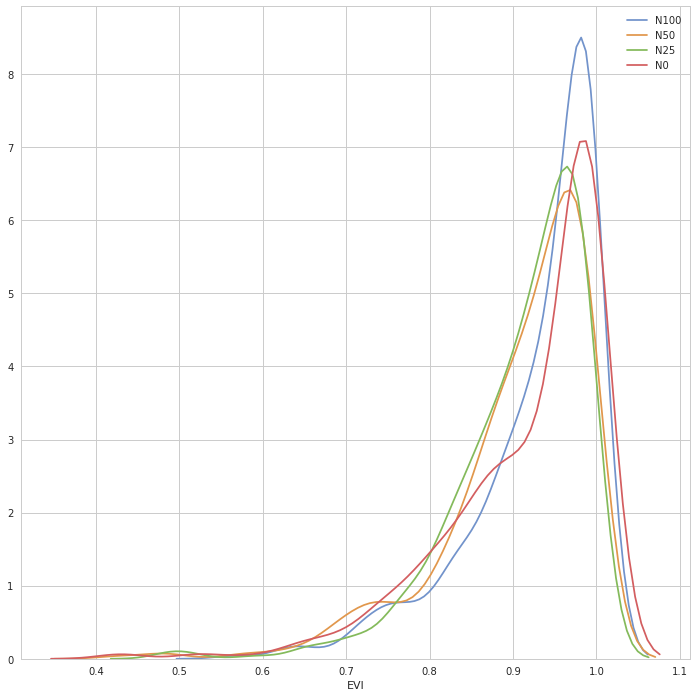

In [9]:
sns.distplot(nitrogen_evi[100], bins=16, hist=False, color="#7293CB", label="N100")
sns.distplot(nitrogen_evi[50],  bins=16, hist=False, color="#E1974C", label="N50")
sns.distplot(nitrogen_evi[25],  bins=16, hist=False, color="#84BA5B", label="N25")
sns.distplot(nitrogen_evi[0],   bins=16, hist=False, color="#D35E60", label="N0", axlabel="EVI")

In [10]:
irrigation_avg = {k:np.average(values) for k, values in irrigation_evi.items()}
irrigation_stddev = {k:np.std(values) for k, values in irrigation_evi.items()}

print(irrigation_avg)
print(irrigation_stddev)

{100: 0.94142986091843917, 50: 0.92209871636927143, 25: 0.91787917211593262, 0: 0.87772375908318201}
{100: 0.067032591488152007, 50: 0.076116101869656949, 25: 0.081133620909718651, 0: 0.10419476269170591}


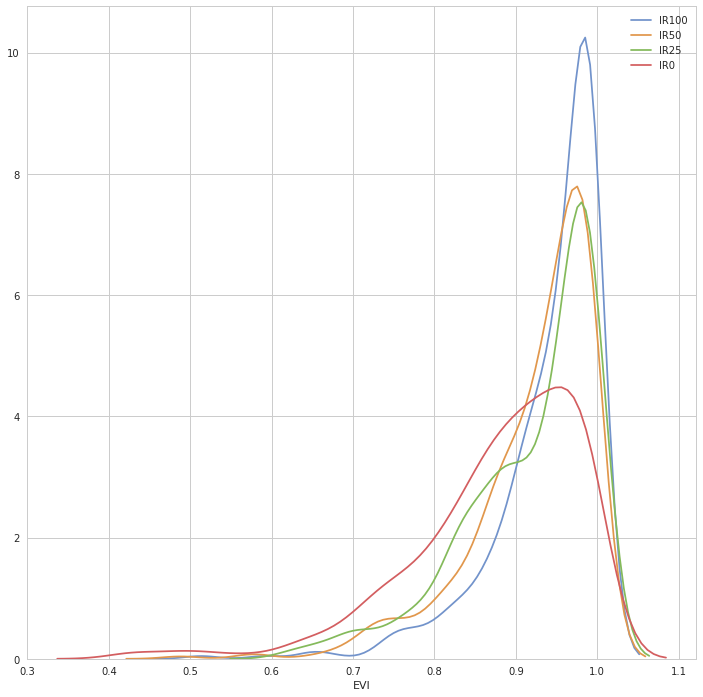

In [11]:
sns.distplot(irrigation_evi[100], bins=16, hist=False, color="#7293CB", label="IR100")
sns.distplot(irrigation_evi[50],  bins=16, hist=False, color="#E1974C", label="IR50")
sns.distplot(irrigation_evi[25],  bins=16, hist=False, color="#84BA5B", label="IR25")
sns.distplot(irrigation_evi[0],   bins=16, hist=False, color="#D35E60", label="IR0", axlabel="EVI")

### Analyze ground data

In [12]:
df = pd.read_csv(csv_file)
df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count
0,0,0,1,104,48.9,0.805878,-4.80,6,7
1,0,0,1,113,44.4,0.815393,NaN,6,7
2,0,0,2,104,48.8,0.839747,-4.24,4,6
3,0,0,2,113,53.5,0.819832,NaN,4,6
4,0,0,3,104,51.9,0.812323,-4.82,7,6


In [13]:
pre_df = {
    "Nitrogen": [],
    "Irrigation": [],
    "Replication": [],
    "Plant Number": [],
    "uav_evi": [],
}
for k, v in lettuce_evi.items():
    nitrogen = int(re.search("N(.*)IR.*", k).group(1))
    irrigation = int(re.search(".*IR(.*)Rep.*", k).group(1))
    replication = int(re.search(".*Rep(.*)_", k).group(1))
    number = int(re.search(".*_(.*)", k).group(1))
    
    if number == 104 or number == 113:
        pre_df["Nitrogen"].append(nitrogen)
        pre_df["Irrigation"].append(irrigation)
        pre_df["Replication"].append(replication)
        pre_df["Plant Number"].append(number)
        pre_df["uav_evi"].append(v)

evi_df = pd.DataFrame(data=pre_df)

In [14]:
merged_df = pd.merge(df, evi_df, on=["Nitrogen", "Irrigation", "Replication", "Plant Number"])
merged_df.head()

,Nitrogen,Irrigation,Replication,Plant Number,Chlorophyll,NDVI,WP,Average Height,Average Leaf Count,uav_evi
0,0,0,1,104,48.9,0.805878,-4.80,6,7,0.828819
1,0,0,1,113,44.4,0.815393,NaN,6,7,0.868869
2,0,0,2,104,48.8,0.839747,-4.24,4,6,0.795928
3,0,0,2,113,53.5,0.819832,NaN,4,6,0.826873
4,0,0,3,104,51.9,0.812323,-4.82,7,6,0.985884


In [15]:
print("UAV EVI & Chlorophyll:", stats.pearsonr(merged_df["uav_evi"], merged_df["Chlorophyll"])[0])
print("UAV EVI & NDVI:", stats.pearsonr(merged_df["uav_evi"], merged_df["NDVI"])[0])
print("UAV EVI & Height:", stats.pearsonr(merged_df["uav_evi"], merged_df["Average Height"])[0])
print("UAV EVI & Leaf Count:", stats.pearsonr(merged_df["uav_evi"], merged_df["Average Leaf Count"])[0])
print("UAV EVI & WP:", stats.pearsonr(merged_df.dropna()["uav_evi"], merged_df.dropna()["WP"])[0])


UAV EVI & Chlorophyll: 0.0910794783404
UAV EVI & NDVI: 0.0936331817064
UAV EVI & Height: 0.22110327436
UAV EVI & Leaf Count: -0.0249018734992
UAV EVI & WP: 0.308062909107
UAV EVI & Irrigation: 0.269179244808
UAV EVI & Nitrogen: 0.140950173469


In [17]:
# Drop data of area with broken irrigation
df = df[(df.Nitrogen != 25) | (df.Irrigation != 0) | (df.Replication != 3)]

In [18]:
print("UAV EVI & Irrigation:", stats.pearsonr(merged_df["uav_evi"], merged_df["Irrigation"])[0])
print("UAV EVI & Nitrogen:", stats.pearsonr(merged_df["uav_evi"], merged_df["Nitrogen"])[0])

UAV EVI & Irrigation: 0.269179244808
UAV EVI & Nitrogen: 0.140950173469


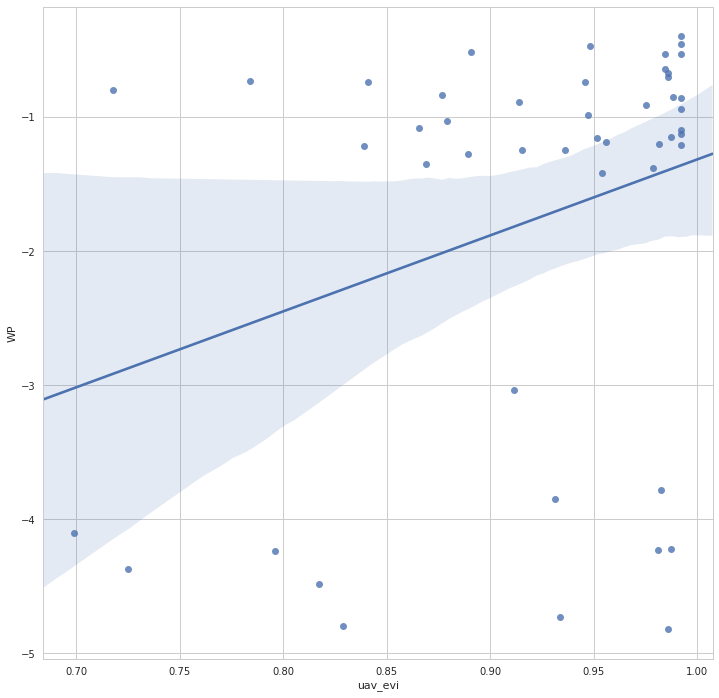

In [16]:
sns.regplot(x=merged_df["uav_evi"], y=merged_df["WP"])